In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import networkx as nx
from orinoco import (get_distance_along_channel_using_fmm,
                     get_distance_segments,
                     get_undirected_channel_network,
                     direct_channel_network_using_distance,
                     export_edges_to_geodataframe,
                     export_nodes_to_geodataframe,
                     get_map_centroid_from_binary_mask,
                     apply_func_to_superpixels,
                     get_array_from_features,
                     get_width_features_from_segments,
                     add_flow_attributes,
                     change_tuples_to_vector,
                     get_geopandas_features_from_array,
                     get_RAG_neighbors,
                     get_segment_df,
                     get_width_features_from_segments,
                     get_geo_width_df,
                     update_graph_with_widths,
                     add_width_features_to_graph,
                     )
from skimage.color import label2rgb
import random
from shapely.geometry import Point, LineString, MultiLineString, GeometryCollection
from shapely.ops import unary_union
import geopandas as gpd
import scipy.ndimage as nd
from scipy.ndimage import find_objects
from rasterio import features
from tqdm import tqdm
from rasterio.transform import rowcol

This uess the normal workflow from before but there is a small trick employed to overcome this [problem](https://github.com/scikit-fmm/scikit-fmm/issues/32).

We have a 1-pixel dilated water mask and compute distance through this. Then, we mask out the dilated pixels after the distance has been computed.

To ensure that all the pixels we reached using fmm are still reachable after this contraction, we specify a connectivity of 8 in relevant steps.

# Initialize Paths for Data And Output

In [2]:
tile_name = 'NR08'

In [3]:
out = Path('out')
out.mkdir(exist_ok=True)

tile_dir = Path(f'out/{tile_name}')
tile_dir.exists()

True

# Read Data

In [4]:
with rasterio.open(out/f'{tile_name}/water_mask_dilated_{tile_name}.tif') as ds:
    water_mask_d = ds.read(1)
with rasterio.open(out/f'{tile_name}/water_mask_{tile_name}.tif') as ds:
    water_mask = ds.read(1)
with rasterio.open(out/f'{tile_name}/ocean_mask_{tile_name}.tif') as ds:
    ocean_mask = ds.read(1)
    profile = ds.profile

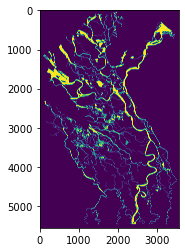

In [5]:
plt.imshow(water_mask)

# Make Products

## The distance

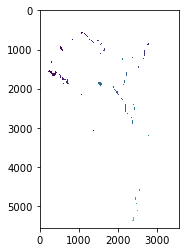

In [6]:
transform = profile['transform']
dx, dy = transform.a, -transform.e
dist = get_distance_along_channel_using_fmm(water_mask_d,
                                          ocean_mask,
                                          dx=dx,
                                          dy=dy,
                                          # removes areas with less than 2.5% of total size
                                          area_threshold=.025
                                          )
dist[water_mask == 0] = np.nan
plt.imshow(dist, interpolation='none')

In [7]:
p = profile.copy()
p['dtype'] = 'float32'
with rasterio.open(tile_dir/f'distance_{tile_name}.tif', 'w', **p) as ds:
    ds.write(dist.astype(np.float32), 1)

# Segmentation

In [8]:
pixel_step = 5
segments, interface_adj_segments = get_distance_segments(dist,
                                                         pixel_step,
                                                         dx=dx,
                                                         dy=dy)

rag neighbors: 100%|██████████| 4098/4098 [00:00<00:00, 17786.60it/s]


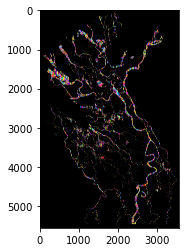

In [9]:
segments_rgb = label2rgb(segments, bg_label=0)
plt.imshow(segments_rgb, interpolation='non')

In [10]:
p = profile.copy()
p['dtype'] = 'int32'
with rasterio.open(tile_dir/f'segments_{tile_name}.tif', 'w', **p) as ds:
    ds.write(segments.astype(np.int32), 1)

In [11]:
p = profile.copy()
p['dtype'] = 'float32'
p['count'] = 3

with rasterio.open(tile_dir/f'segments_rgb_{tile_name}.tif', 'w', **p) as ds:
    ds.write(segments_rgb.transpose([2, 0, 1]).astype(np.float32))

# Undirected Network

In [12]:
chanG_undirected = get_undirected_channel_network(segments, 
                                               dist, 
                                               profile, 
                                               interface_adj_segments,
                                               connectivity=8)

adding edges: 100%|██████████| 26399/26399 [00:00<00:00, 176262.46it/s]


# Directed Network

In [13]:
chanG = direct_channel_network_using_distance(chanG_undirected, 
                                              remove_danlging_segments=True, 
                                              segment_threshold=3,
                                              meters_to_interface_filter_buffer=1_000,
                                             )

In [14]:
df_edges = export_edges_to_geodataframe(chanG, profile['crs'])
df_edges.head()

,length_m,weight,segment_id,edges_in_segment,cc_id,geometry
0,587.801438,587.801438,0,25,0,"LINESTRING (507790.851 7703858.191, 507384.036..."
1,166.916971,166.916971,1,12,0,"LINESTRING (507790.851 7703858.191, 507954.783..."
2,158.593817,158.593817,0,25,0,"LINESTRING (507384.036 7704282.470, 507251.824..."
3,151.984882,151.984882,0,25,0,"LINESTRING (507251.824 7704370.059, 507149.634..."
4,159.198870,159.198870,0,25,0,"LINESTRING (507149.634 7704482.561, 507030.904..."


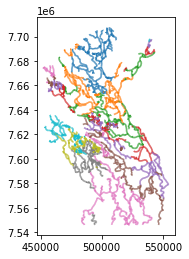

In [15]:
df_edges.plot(column='segment_id', categorical=True)

# Widths

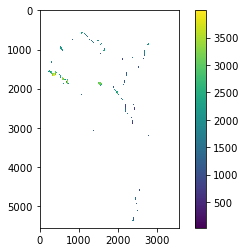

In [16]:
width_features = get_width_features_from_segments(segments, profile)
widths = get_array_from_features(segments, width_features)
plt.imshow(widths, interpolation='none')
plt.colorbar()

In [17]:
chanG = add_width_features_to_graph(chanG, width_features.ravel())

In [18]:
chanG = add_flow_attributes(chanG, dist, profile['transform'])

flow vector computation using network: 100%|██████████| 24937/24937 [00:03<00:00, 8000.56it/s]


This takes a bit of time to polygonize the segments, so be patient.

In [27]:
%%time

df_segments = get_segment_df(segments, chanG, profile)
df_segments.head()

CPU times: user 23.6 s, sys: 228 ms, total: 23.8 s
Wall time: 23.7 s


,label,geometry,perimeter,node,flow_vector_perp
0,1,"POLYGON ((506385.000 7707765.000, 506385.000 7...",1800.0,"(506205.0, 7707614.368421053)","(0.89259404, 0.4508613)"
1,2,"POLYGON ((506415.000 7707615.000, 506415.000 7...",1800.0,"(506262.2727272727, 7707471.363636363)","(0.90515715, 0.42507705)"
2,3,"POLYGON ((506535.000 7707495.000, 506535.000 7...",1920.0,"(506308.08510638296, 7707324.893617021)","(0.9202143, 0.3914148)"
3,4,"POLYGON ((506565.000 7707345.000, 506565.000 7...",1920.0,"(506368.9393939394, 7707186.515151516)","(0.9279651, 0.37266707)"
4,5,"POLYGON ((506685.000 7707255.000, 506685.000 7...",2160.0,"(506427.36842105264, 7707052.631578947)","(0.92727506, 0.37438077)"


In [28]:
df_segments_out = change_tuples_to_vector(df_segments)
df_segments_out.to_file(tile_dir/'segments.geojson', 
                        driver='GeoJSON')

This is the most expensive computation, so be very patient.

In [29]:
%%time

df_geo_widths = get_geo_width_df(df_segments, chanG, radius=1)
df_geo_widths.head()

CPU times: user 3min 11s, sys: 350 ms, total: 3min 12s
Wall time: 3min 12s


,label,node,geometry,width_m
0,1,"(506205.0, 7707614.368421053)","LINESTRING (506475.000 7707750.749, 505965.000...",571.368401
1,2,"(506262.2727272727, 7707471.363636363)","LINESTRING (506535.000 7707599.441, 506025.000...",563.438085
2,3,"(506308.08510638296, 7707324.893617021)","LINESTRING (506565.000 7707434.173, 506055.000...",554.218723
3,4,"(506368.9393939394, 7707186.515151516)","LINESTRING (506655.000 7707301.396, 506115.000...",581.918450
4,5,"(506427.36842105264, 7707052.631578947)","LINESTRING (506775.000 7707192.985, 506115.000...",711.762935


In [30]:
df_geo_widths_out = change_tuples_to_vector(df_geo_widths)
df_geo_widths_out.to_file(tile_dir/'width_geometries.geojson', 
                          driver='GeoJSON')

In [31]:
chanG = update_graph_with_widths(chanG, df_geo_widths)

In [32]:
node_data =dict(chanG.nodes(data=True))
random.choice(list(node_data.items()))

((516825.0, 7576680.0),
 {'label': 22928,
  'meters_to_interface': 121556.88284744482,
  'x': 516825.0,
  'y': 7576680.0,
  'interface_adj': False,
  'graph_degree': 2,
  'width_from_segment': 30.0,
  'flow_vector_perp_grad': None,
  'flow_vector_network': (-0.23592367982889162, -0.9717715869976826),
  'flow_vector_perp_network': (0.9717715869976826, -0.23592367982889162),
  'flow_vector_perp': (0.9717715869976826, -0.23592367982889162),
  'width_m': 30.87147268092663})

# Save Network

In [33]:
df_nodes = export_nodes_to_geodataframe(chanG, profile['crs'])
df_nodes = change_tuples_to_vector(df_nodes)
df_edges = export_edges_to_geodataframe(chanG, profile['crs'])

In [34]:
df_edges.to_file(tile_dir/f'{tile_name}_edges.geojson', driver='GeoJSON')
df_nodes.to_file(tile_dir/f'{tile_name}_nodes.geojson', driver='GeoJSON')
nx.write_gpickle(chanG, tile_dir/f'{tile_name}_network.pkl')